## Import libraries, as usual...

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sklearn
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA

import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split
from sklearn.metrics import rand_score, calinski_harabasz_score, silhouette_score

## Load dataset...

In [2]:
data = pd.read_csv('./data/housing_clean.csv')
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_bedrooms_mean,total_bedrooms_median,median_house_value_range,total_bedrooms_median_prange
0,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,190.0,190.0,"(338333.667, 370667.133]",190.0
1,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,235.0,235.0,"(338333.667, 370667.133]",235.0
2,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,280.0,280.0,"(338333.667, 370667.133]",280.0
3,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,213.0,213.0,"(241333.267, 273666.733]",213.0
4,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,489.0,489.0,"(273666.733, 306000.2]",489.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18179,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,374.0,374.0,"(47332.467, 79665.933]",374.0
18180,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,150.0,150.0,"(47332.467, 79665.933]",150.0
18181,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,485.0,485.0,"(79665.933, 111999.4]",485.0
18182,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,409.0,409.0,"(79665.933, 111999.4]",409.0


## Select features for Scaling
##### More information regarding SelectKBest:
  * ##### https://scikit-learn.org/stable/modules/feature_selection.html
  * ##### https://medium.com/@Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48#1cb1

<AxesSubplot:>

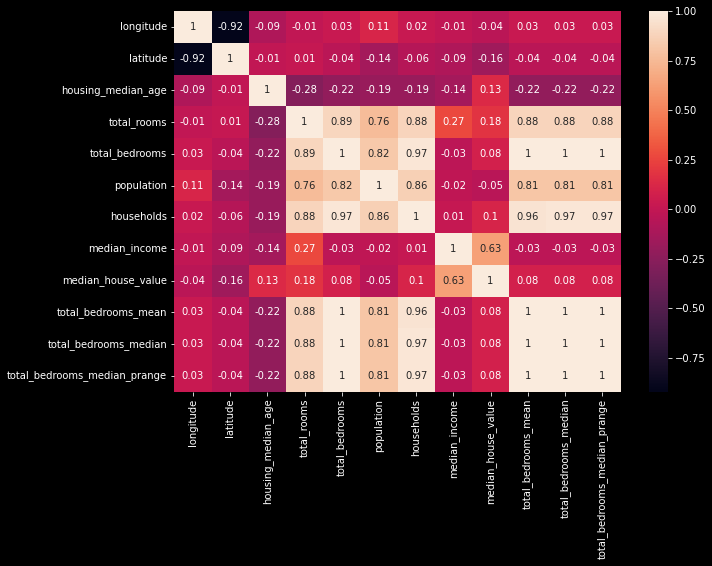

In [3]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
sns.heatmap(data.drop(['ocean_proximity', 'median_house_value_range'], axis=1).corr().round(2), annot=True, ax=ax)

In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
skb = SelectKBest(mutual_info_classif, k='all').fit(data.drop(['total_bedrooms', 'median_house_value_range', 'ocean_proximity'], axis=1), data['ocean_proximity'])

In [5]:
pd.Series(skb.scores_, index=skb.get_feature_names_out()).sort_values(ascending=False)

longitude                       0.714518
latitude                        0.637524
median_house_value              0.216850
housing_median_age              0.074062
median_income                   0.032697
households                      0.011165
population                      0.007643
total_bedrooms_mean             0.006316
total_bedrooms_median_prange    0.005806
total_bedrooms_median           0.003582
total_rooms                     0.000000
dtype: float64

In [6]:
feats = ['longitude', 'latitude', 'median_house_value', 'housing_median_age', 'median_income', 'households'] # maybe "total_bedrooms_median" as well
targets = ['ocean_proximity', 'median_house_value_range']

X, y = data[feats].copy(), data[targets[0]].copy()

In [7]:
X

,longitude,latitude,median_house_value,housing_median_age,median_income,households
0,-122.24,37.85,352100.0,52.0,7.2574,177.0
1,-122.25,37.85,341300.0,52.0,5.6431,219.0
2,-122.25,37.85,342200.0,52.0,3.8462,259.0
3,-122.25,37.85,269700.0,52.0,4.0368,193.0
4,-122.25,37.84,299200.0,52.0,3.6591,514.0
...,...,...,...,...,...,...
18179,-121.09,39.48,78100.0,25.0,1.5603,330.0
18180,-121.21,39.49,77100.0,18.0,2.5568,114.0
18181,-121.22,39.43,92300.0,17.0,1.7000,433.0
18182,-121.32,39.43,84700.0,18.0,1.8672,349.0


In [8]:
y

0        NEAR BAY
1        NEAR BAY
2        NEAR BAY
3        NEAR BAY
4        NEAR BAY
           ...   
18179      INLAND
18180      INLAND
18181      INLAND
18182      INLAND
18183      INLAND
Name: ocean_proximity, Length: 18184, dtype: object

## Split to train/test sets...

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

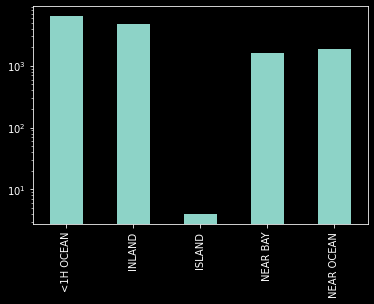

In [10]:
ax_train = y_train.value_counts(sort=False).sort_index().plot.bar()
ax_train.set_yscale('log')

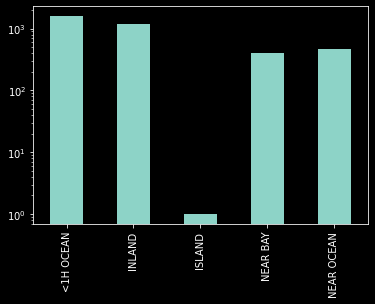

In [11]:
ax_test = y_test.value_counts(sort=False).sort_index().plot.bar()
ax_test.set_yscale('log')

## Normalize train/test sets...

In [12]:
# MinMaxScaler 
# scaler = MinMaxScaler(feature_range=(0, 1), clip=True)
scaler = StandardScaler()
oenc = OrdinalEncoder()


X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_enc = oenc.fit_transform(y.values.reshape(-1,1))

In [13]:
X_train_scaled

array([[ 0.96990695, -0.73407569, -0.31938687, -0.78908953, -0.27188987,
         0.20369274],
       [ 0.78008244, -0.87773306,  0.58678848, -0.30136656,  1.48567617,
         0.74347952],
       [-0.0391602 , -0.5811501 ,  0.37544108,  0.6740794 , -0.62542289,
        -0.37013466],
       ...,
       [-0.08911401,  0.52176776, -1.21714574,  0.34893075, -1.20147096,
         0.07239325],
       [-1.14813498,  1.08712902, -0.69625857, -1.43938684, -1.00602127,
        -0.36527172],
       [ 0.35047959, -0.69236871,  0.99077997, -0.78908953,  1.50089203,
        -1.14334276]])

In [14]:
y_enc

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

## Cluster dataset using K-Means...

In [15]:
kmeans = KMeans(n_clusters=y.nunique(), random_state=42)
kmeans.fit(X=X_train_scaled)

KMeans(n_clusters=5, random_state=42)

In [16]:
kmeans.predict(X_test_scaled)

array([0, 2, 1, ..., 3, 1, 1], dtype=int32)

In [17]:
y_test.shape, kmeans.predict(X_test_scaled).shape

((3637,), (3637,))

In [18]:
rand_score(oenc.transform(y_test.values.reshape((-1,1))).flatten(), kmeans.predict(X_test_scaled)),\
calinski_harabasz_score(X_test, kmeans.predict(X_test_scaled)),

(0.6613928233626222, 1171.3768814658654)

## Visualize Results using PCA...

In [19]:
pca2d = PCA(n_components=2)
X_train_scaled_2d = pca2d.fit_transform(X_train_scaled)
X_test_scaled_2d = pca2d.transform(X_test_scaled)

In [20]:
pca2d.explained_variance_ratio_, np.sum(pca2d.explained_variance_ratio_)

(array([0.32838109, 0.2687312 ]), 0.5971122887779321)

In [21]:
oenc.transform(y_test.values.reshape(-1,1))

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [3.],
       [0.]])

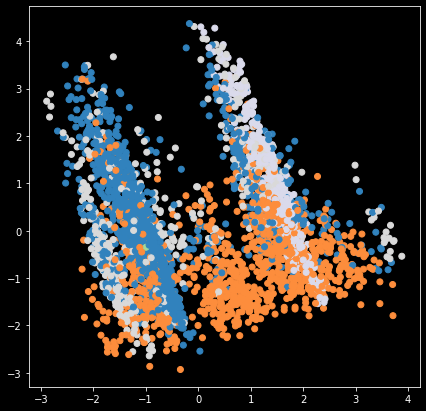

In [22]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.scatter(X_test_scaled_2d[:,0], X_test_scaled_2d[:,1], c=oenc.transform(y_test.values.reshape(-1,1)), cmap='tab20c')

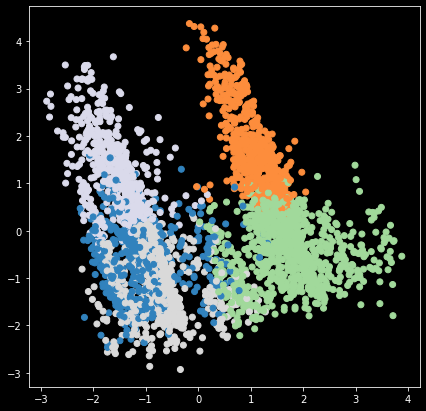

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.scatter(X_test_scaled_2d[:,0], X_test_scaled_2d[:,1], c=kmeans.predict(X_test_scaled), cmap='tab20c')

## How to find the optimal **k**?

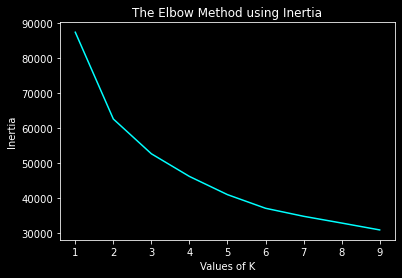

In [24]:
# Elbow Criterion
inertias = []
K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train_scaled)
    inertias.append(kmeanModel.inertia_)
    
plt.plot(K, inertias, 'cyan')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

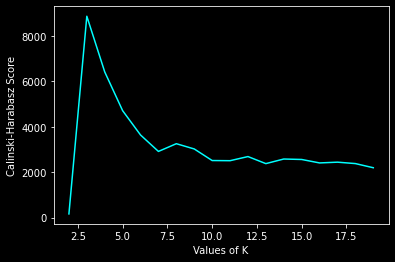

In [25]:
# Calinski-Harabasz Score
ch_scores = []
K = range(2, 20)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_train_scaled)
    ch_scores.append(calinski_harabasz_score(X_train, kmeanModel.predict(X_train_scaled)),)
    
plt.plot(K, ch_scores, 'cyan')
plt.xlabel('Values of K')
plt.ylabel('Calinski-Harabasz Score')
plt.show()

##### Higher value of CH index means the clusters are dense and well separated, although there is no “acceptable” cut-off value. We need to choose that solution which gives a peak or at least an abrupt elbow on the line plot of CH indices. On the other hand, if the line is smooth (horizontal or ascending or descending) then there is no such reason to prefer one solution over others. [source: Geeks-for-Geeks](https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/)

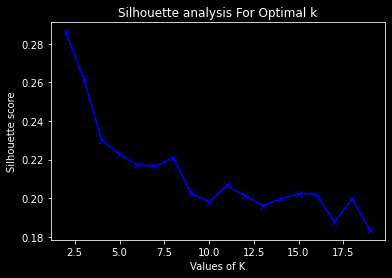

In [26]:
silhouette_scores = []
K = range(2, 20)
  
for k in K:
    # initialise kmeans
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_scaled)

    # silhouette score
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))
    

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

## Running k-Means for the best **k**

In [27]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X=X_test_scaled)

KMeans(n_clusters=2, random_state=42)

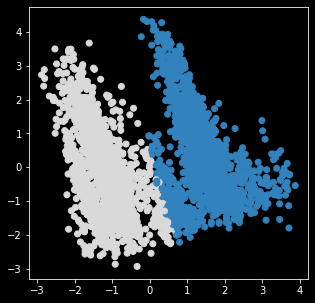

In [28]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(X_test_scaled_2d[:,0], X_test_scaled_2d[:,1], c=kmeans.predict(X_test_scaled), cmap='tab20c')

In [29]:
rand_score(y_test, kmeans.predict(X_test_scaled))

0.591272228680113

## Clustering dataset with DBSCAN...

In [30]:
dbscan = DBSCAN(n_jobs=-1)
dbscan.fit(X_train_scaled, y=y_enc)

DBSCAN(n_jobs=-1)

In [31]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55])

In [32]:
dbscan.core_sample_indices_, dbscan.core_sample_indices_.shape

(array([    0,     1,     3, ..., 14542, 14543, 14544]), (9170,))

In [33]:
np.where(dbscan.labels_ == -1), np.where(dbscan.labels_ == -1)[0].shape

((array([   12,    27,    34, ..., 14536, 14545, 14546]),), (3370,))

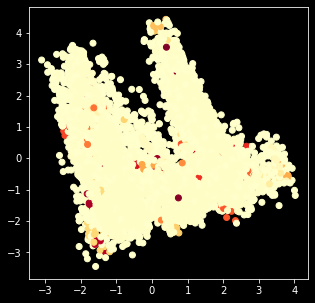

In [34]:
# DBSCAN does not have a predict method (why? - starting point: https://stackoverflow.com/a/69239363)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(X_train_scaled_2d[:, 0], X_train_scaled_2d[:, 1], c=dbscan.labels_, cmap='YlOrRd')

Text(0, 0.5, 'Distance')

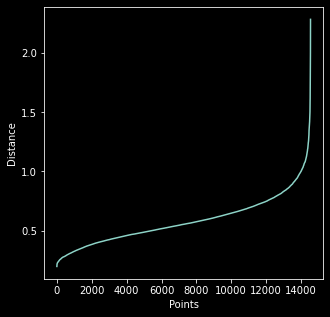

In [35]:
# Finding the Optimal value of EPS
# Sources: 
# [1] https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan
# [2] https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/
from sklearn.neighbors import NearestNeighbors


nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X_train_scaled)

distances, indices = neighbors.kneighbors(X_train_scaled)
distances = np.sort(distances[:,10], axis=0)


fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.8037902408781932


<Figure size 360x360 with 0 Axes>

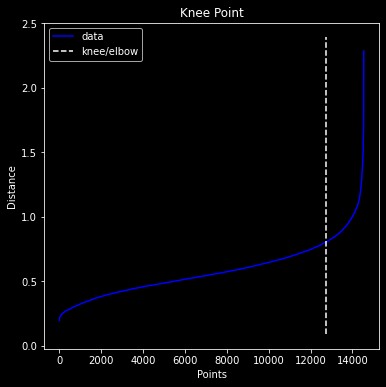

In [36]:
from kneed import KneeLocator

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [37]:
dbscan = DBSCAN(eps=0.8024758225927446, n_jobs=-1)
dbscan.fit(X_train_scaled)

DBSCAN(eps=0.8024758225927446, n_jobs=-1)

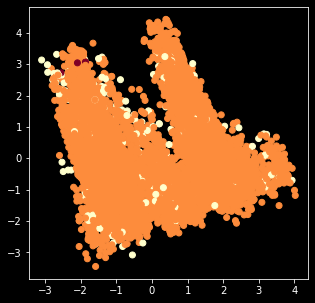

In [38]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(X_train_scaled_2d[:, 0], X_train_scaled_2d[:, 1], c=dbscan.labels_, cmap='YlOrRd')

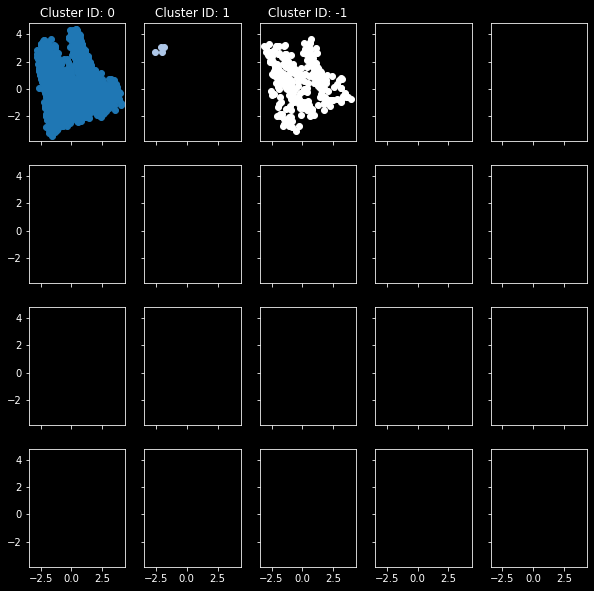

In [39]:
fig, ax = plt.subplots(4,5, figsize=(10, 10), sharex=True, sharey=True)
ax_flat = ax.flatten()

for i, cluster_id in enumerate(set(dbscan.labels_)):
    mask = dbscan.labels_ == cluster_id
    ax_flat[i].scatter(X_train_scaled_2d[mask, 0], X_train_scaled_2d[mask, 1], color=plt.cm.tab20(cluster_id) if cluster_id != -1 else 'white')
    ax_flat[i].set_title(f'Cluster ID: {cluster_id}')

plt.show()

In [40]:
y_train.shape, dbscan.labels_.shape

((14547,), (14547,))

In [41]:
from sklearn.cluster import HDBSCAN

In [42]:
hdbscan = HDBSCAN(min_cluster_size=33)
hdbscan.fit(X_train)

HDBSCAN(min_cluster_size=33)

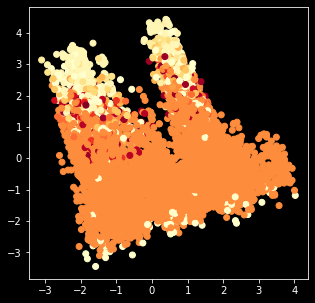

In [43]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(X_train_scaled_2d[:, 0], X_train_scaled_2d[:, 1], c=hdbscan.labels_, cmap='YlOrRd')

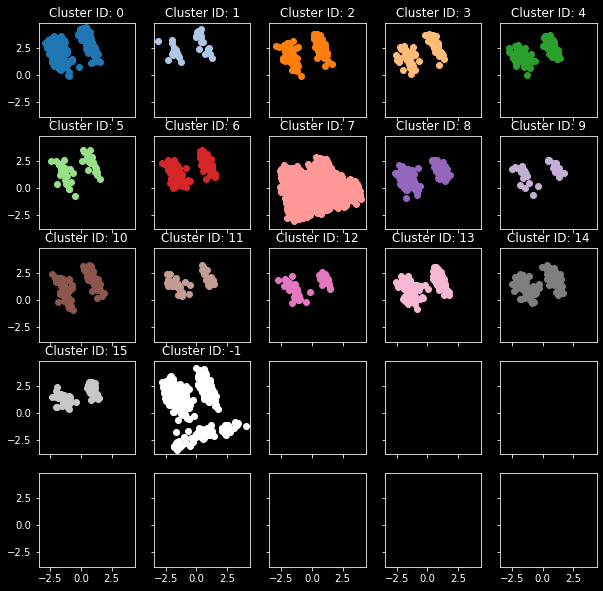

In [44]:
fig, ax = plt.subplots(5,5, figsize=(10, 10), sharex=True, sharey=True)
ax_flat = ax.flatten()

for i, cluster_id in enumerate(set(hdbscan.labels_)):
    mask = hdbscan.labels_ == cluster_id
    ax_flat[i].scatter(X_train_scaled_2d[mask, 0], X_train_scaled_2d[mask, 1], color=plt.cm.tab20(cluster_id) if cluster_id != -1 else 'white')
    ax_flat[i].set_title(f'Cluster ID: {cluster_id}')

plt.show()

## Extra: Analyzing Clusters...
### ...via diplaying them on the map, and
### ...using association rules (apriori algorithm; [tutorial](https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c))

In [45]:
# !pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

In [46]:
import geopandas as gpd

cluster = gpd.GeoDataFrame(gdf := X_train[hdbscan.labels_ == 11], geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude), crs=4326)
# cluster = gpd.GeoDataFrame(gdf := X_train.loc[kmeans.predict(X_train_scaled) == 0], geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude), crs=4326)

In [47]:
cluster.explore()

In [48]:
for col in cluster.columns[:-1]:
    cluster.loc[:, f'{col}_bin'] = pd.cut(cluster[col], bins=5, include_lowest=True)

In [49]:
freq_items = apriori(
    pd.get_dummies(cluster).iloc[:, 7:].astype(bool), use_colnames=True, max_len=None, verbose=0, min_support=0.2,
)

In [50]:
freq_items

,support,itemsets
0,0.425,"(longitude_bin_(-122.787, -121.538])"
1,0.325,"(longitude_bin_(-119.054, -117.812])"
2,0.250,"(latitude_bin_(32.713, 33.864])"
3,0.300,"(latitude_bin_(33.864, 35.008])"
4,0.375,"(latitude_bin_(37.296, 38.44])"
5,0.200,"(median_house_value_bin_(345120.0, 345540.0])"
6,0.275,"(median_house_value_bin_(345540.0, 345960.0])"
7,0.225,"(median_house_value_bin_(345960.0, 346380.0])"
8,0.275,"(housing_median_age_bin_(23.8, 33.2])"
9,0.225,"(housing_median_age_bin_(33.2, 42.6])"


In [51]:
association_rules(
    freq_items, metric='confidence', min_threshold=0.7, support_only=False 
)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(longitude_bin_(-122.787, -121.538])","(latitude_bin_(37.296, 38.44])",0.425,0.375,0.375,0.882353,2.352941,0.215625,5.3125,1.000000
1,"(latitude_bin_(37.296, 38.44])","(longitude_bin_(-122.787, -121.538])",0.375,0.425,0.375,1.000000,2.352941,0.215625,inf,0.920000
2,"(latitude_bin_(33.864, 35.008])","(longitude_bin_(-119.054, -117.812])",0.300,0.325,0.225,0.750000,2.307692,0.127500,2.7000,0.809524
3,"(latitude_bin_(33.864, 35.008])","(households_bin_(243.0, 412.0])",0.300,0.375,0.225,0.750000,2.000000,0.112500,2.5000,0.714286
